## Imports

In [40]:
from gluoncv import data, utils
%matplotlib inline
from matplotlib import pyplot as plt
import h5py
import pickle
import numpy as np

from utils import batch_iou
from ssd import SSD300

## Constants

In [13]:
DATA_PATH = 'data.h5'
TRAIN_ROOT = '~/datasets/voc'
TEST_ROOT = '~/datasets/voc'
IMG_HEIGHT = 333
IMG_WIDTH = 500

## Utility functions

In [69]:
def to_absolute_coordinates(bb_predictions):
    abs_coordinates = np.empty_like(bb_predictions)
    abs_coordinates[:, :, :2] = bb_predictions[:, :, :2] - bb_predictions[:, :, 2:]
    abs_coordinates[:, :, 0] = abs_coordinates[:, :, 0] * IMG_WIDTH
    abs_coordinates[:, :, 1] = abs_coordinates[:, :, 1] * IMG_HEIGHT
    abs_coordinates[:, :, 2:] = bb_predictions[:, :, :2] + bb_predictions[:, :, 2:]
    abs_coordinates[:, :,  2] = abs_coordinates[:, :, 2] * IMG_WIDTH
    abs_coordinates[:, :, 3] = abs_coordinates[:, :, 3] * IMG_HEIGHT
    return abs_coordinates

def get_best_prediction_box(abs_predictions, bounding_boxes):
    bb = np.empty_like(abs_predictions)
    bb[:] = bounding_boxes
    ious = batch_iou(abs_predictions, bb)
    ind = np.argmax(ious)
    return abs_predictions[ind], ious[ind]

## Load preprocessed and unprocessed data

In [23]:
with h5py.File(DATA_PATH, 'r') as f:
    anchors = f['main']['anchors'][:]
    data = f['main']['image'][:]
    bounding_boxes = f['main']['bounding_box'][:]
    classes = f['main']['class'][:]

with open('single_data.pickle', 'rb') as f:
    train_image, train_label = pickle.load(f)
    train_image = train_image.asnumpy()
    bounding_boxes = train_label[:, :4]
    class_ids = train_label[:, 4:5]

## Load model

In [14]:
model = SSD300()

/home/cszsolnai/Projects/ssd/ssd.py:256: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  self.model = Model(input=vgg16_model.input, output=[confidence, localization])


## Train model

In [31]:
class_predictions, bb_predictions = model.predict(data)

abs_predictions = to_absolute_coordinates(bb_predictions)

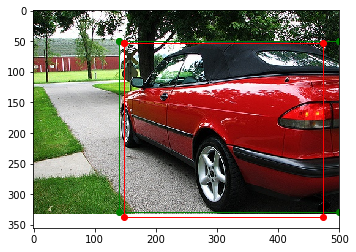

0.8680625


In [70]:
plt.imshow(train_image)

# Draw correct boundimg box
x1, y1, x2, y2 = bounding_boxes.ravel()
x = np.array([x1, x1, x2, x2, x1])
y = np.array([y1, y2, y2, y1, y1])
plt.plot(x, y, 'ro-', linewidth=1, color='g')

# Draw best estimation
best_prediction, iou = get_best_prediction_box(abs_predictions[0], bounding_boxes)
x1, y1, x2, y2 = best_prediction.ravel()
x = np.array([x1, x1, x2, x2, x1])
y = np.array([y1, y2, y2, y1, y1])
plt.plot(x, y, 'ro-', linewidth=1, color='r')

plt.show()

print(iou)

In [ ]:
model.fit(data, y={'confidence': classes, 'localization': bounding_boxes}, epochs=10)

In [ ]:
class_predictions, bb_predictions = model.predict(data)